In [1]:
# Part I - Probability
#To get started, let's import our libraries.

In [71]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [72]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [73]:
# find the number of rows in the dataset.
df.shape[0]

294478

In [74]:
# find  The number of unique users in the dataset.
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [75]:
# number of users converted
(df.converted == 1).sum()

35237

In [76]:
# find The proportion of users converted.
df.converted.mean()*100 

11.96591935560551

In [77]:
# The number of times when the "group" is treatment but "landing_page" is not a new_page.
# here we have 2 cases(1) group = treatment, landing_page = old_page.(2)group = control,landing_page = new_page
(df.query('group == "treatment"')['landing_page'] == 'old_page').sum() +(df.query('group == "control"')['landing_page'] == 'new_page').sum() 

3893

In [78]:
# Do any of the rows have missing values?
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [79]:
# Remove the inaccurate rows
df1 = df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index)

In [80]:
#store the result in a new dataframe df2
df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)

<ipython-input-80-4724728327f5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)


In [81]:
#Check all of the incorrect rows were removed from df2
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [82]:
#Check info of df2
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [83]:
# How many unique user_ids are in df2?
df2['user_id'].nunique()

290584

In [84]:
#find user_id repeated in df2. What is it?and dispaly them?
duplicate = df2[df2.duplicated('user_id',keep = False)]
duplicate

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [85]:
#Remove one of the rows with a duplicate user_id, from the df2 dataframe
df2.drop(labels=1899, inplace=True)

In [86]:
# Check if the row with a duplicate user_id is deleted or not
(df2.user_id == 773192).sum()

1

In [87]:
# Check again if the row with a duplicate user_id is deleted or not
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [88]:
# What is the probability of an individual converting regardless of the page they receive?
df.converted.mean()

0.11965919355605512

In [89]:
# Given that an individual was in the control group, what is the probability they converted?
control_mean = (df2.query('group == "control"')['converted'] == 1).mean()
control_mean

0.1203863045004612

In [90]:
#  Given that an individual was in the treatment group, what is the probability they converted?
treatment_mean = (df2.query('group == "treatment"')['converted'] == 1).mean()
treatment_mean

0.11880806551510564

In [91]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_mean - control_mean
obs_diff

-0.0015782389853555567

In [92]:
# What is the probability that an individual received the new page?
new_page_mean = (df2['landing_page'] == 'new_page').mean()
new_page_mean

0.5000619442226688

In [93]:
# old page converted 0.12038 and new page converted 0.1188 and it is clear new page did not increase conversion rate

In [94]:
# For now consider you need to make the decision just based on all the data provided. 
# If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate 
# of 5%, what should your null and alternative hypotheses be? 
#( 𝐻0 :Pold >=  Pnew ) , (𝐻1 : Pold  <  Pnew )

In [95]:
# Part II - A/B Test
#  What is the conversion rate for  𝑝𝑛𝑒𝑤  under the null hypothesis?
P_new = df.converted.mean()
P_new

0.11965919355605512

In [96]:
# What is the conversion rate for  𝑝𝑜𝑙𝑑  under the null hypothesis?
P_old = df.converted.mean()
P_old

0.11965919355605512

In [97]:
# What is  𝑛𝑛𝑒𝑤 , the number of individuals in the treatment group?
N_new = (df2['landing_page'] == 'new_page').sum()
N_new

145310

In [98]:
# What is  𝑛𝑜𝑙𝑑 , the number of individuals in the control group?
N_old = (df2['landing_page'] == 'old_page').sum()
N_old

145274

In [99]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1, 0], size=N_new, p=[P_new, (1-P_new)])
new_page_converted.mean()

0.11850526460670291

In [100]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0], size=N_old, p=[P_old, (1-P_old)])
old_page_converted.mean()

0.12004901083469857

In [101]:
# Find the difference in the "converted" probability  (𝑝′𝑛𝑒𝑤  -  𝑝′𝑜𝑙𝑑)  for your simulated sample
P_diffs_converted = new_page_converted.mean() - old_page_converted.mean()
P_diffs_converted

-0.0015437462279956626

In [102]:
# Sampling distribution 
p_diffs = []
for _ in range(10000) :
    new_page_converted = np.random.choice([1, 0], size=N_new, p=[P_new, (1-P_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=N_old, p=[P_old, (1-P_old)]).mean()
    p_diffs.append(new_page_converted - old_page_converted)

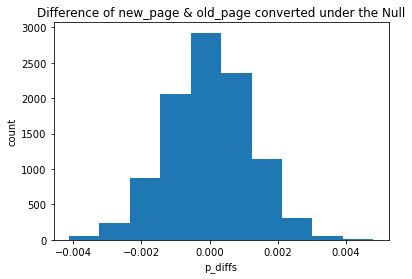

In [103]:
# convert to numpy array
p_diffs = np.array(p_diffs)
# plot sampling distribution
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('count')
plt.title('Difference of new_page & old_page converted under the Null');

In [104]:
# the actual difference observed in the df2 data
obs_diffs = treatment_mean - control_mean
obs_diffs

-0.0015782389853555567

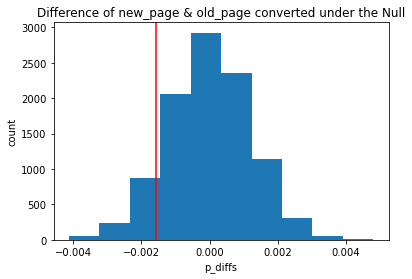

In [105]:
# use plt.axvline() method to mark the actual difference observed 
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('count')
plt.title('Difference of new_page & old_page converted under the Null')
plt.axvline(x= obs_diff, color='r');

In [106]:
# What proportion of the p_diffs are greater than the actual difference observed in the df2 data?
(p_diffs > obs_diffs).mean()

0.9029

In [107]:
# The value calculated is called p-value. For accepting null hypothesis p-value should be greater than suggested p-value. 
# We calculate that almost 90% of the population is above the real diffrence which suggested that: 
# new-page is not doing significantly better than the old page.SO we fail to reject null hypothesis

In [108]:
# Using Built-in Methods for Hypothesis Testing

In [109]:
converted_old = (df2.query('group == "control"')['converted'] == 1).sum()
converted_new = (df2.query('group == "treatment"')['converted'] == 1).sum()
N_old = (df2['landing_page'] == 'old_page').sum()
N_new = (df2['landing_page'] == 'new_page').sum()

In [110]:
converted_old , converted_new , N_old , N_new

(17489, 17264, 145274, 145310)

In [111]:
#  use sm.stats.proportions_ztest() to compute your test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest([converted_old,converted_new] , [N_old,N_new] ,alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


In [112]:
# What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?
# Do they agree with the findings in parts j. and k.?
# The test score is less than the Critical Value for (.05 is 1.645 for one tailed)
#that means the test score lies in the Acceptance Zone and we fail to reject the null Hypothesis.

In [113]:
# Part III - A regression approach

In [114]:
# Since each row in the df2 data is either a conversion or no conversion, 
# what type of regression should you be performing in this case?
# As we have  only two possible outcomes conversion or not conversion so we use Logistic regression

In [116]:
# b. The goal is to use statsmodels library to fit the regression model you specified in part a.
# to see if there is a significant difference in conversion based on the page-type a customer receives. 
# However, you first need to create the following two columns in the df2 dataframe:
# 1- intercept - It should be 1 in the entire column.
# 2- ab_page - It's a dummy variable column, having a value 1 when an individual receives the treatment, otherwise 0.
df2['intercept'] = 1
group_dummies = pd.get_dummies(df2['group'])['treatment']
df3 = df2.join(group_dummies)
df3 = df3.rename(columns={'treatment': 'ab_page'})
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [117]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 04 Jan 2022   Pseudo R-squ.:               8.077e-06
Time:                        18:30:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [118]:
# What is the p-value associated with ab_page? Why does it differ from the value you found in Part II?
# the p-value associated with ab_page is 0.190 and still heiger than the level of .05 and we fail to reject null
# in part 2 ( 𝐻0 :Pold >=  Pnew ) , (𝐻1 : Pold  <  Pnew ) This assumes to be a one-tailed test
# in part 3 ( 𝐻0 :Pold =  Pnew ) , (𝐻1 : Pold  =  Pnew! ) This assumes to be a two-tailed test
# the p value is different from part 2 to part 3 as we have one-tail(part2) and two-tails testing(part3)

In [119]:
# you are considering other things that might influence whether or not an individual converts. 
# Discuss why it is a good idea to consider other factors to add into your regression model. 
# Are there any disadvantages to adding additional terms into your regression model?

In [120]:
# Adding countries
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head(5)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [121]:
# # Join with the df2 dataframe
df4 = countries.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df4.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [122]:
# Create the necessary dummy variables
country_dummies = pd.get_dummies(df4['country'])
df5 = df4.join(country_dummies)
df5.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [123]:
# Fit your model and obtain the results 
lm = sm.Logit(df5['converted'],df5[['intercept','CA','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 04 Jan 2022   Pseudo R-squ.:               1.521e-05
Time:                        18:31:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

In [124]:
# Does it appear that country had an impact on conversion? 
# there is no impact from country on conversion.we notice 2 dummy country have p value heiger than the level of .05

In [125]:
# we would like to look at an interaction between page and country to see if are there significant effects on conversion

In [126]:
df5['CA_ab_page'] = df5['CA'] * df5['ab_page']
df5['US_ab_page'] = df5['US'] * df5['ab_page']
df5.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_ab_page,US_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [127]:
lm = sm.Logit(df5['converted'],df5[['intercept','ab_page','CA','US','CA_ab_page','US_ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 04 Jan 2022   Pseudo R-squ.:               3.482e-05
Time:                        18:31:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
US_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

In [ ]:
# the p value is heiger than the level of .05
# we fail to reject the null hypotheses  This is based on the probability figures, A/B test and regression. 
# There is no strong evidence that the countries (US, CA and UK) influence the conversion rate.